In [ ]:
import torch
import torch.nn as nn
import torchvision
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#import torch.utils.data
from utils import *
import numpy as np
import math
from numpy.random import default_rng
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import sys
from collections import namedtuple
from torch.utils.data import Dataset, DataLoader
from spacetorch.datasets import DatasetRegistry
import spacetorch.analyses.core as core
from spacetorch.utils import (
    figure_utils,
    plot_utils,
    spatial_utils,
    array_utils,
    seed_str,
)
from spacetorch.analyses.floc import get_floc_tissue
from spacetorch.datasets import floc
from spacetorch.maps import nsd_floc
from spacetorch.maps.it_map import ITMap
from spacetorch.paths import PROJ_DIR, RESULTS_DIR
#from spacetorch.constants import RNG_SEED
from spacetorch.feature_extractor import FeatureExtractor
from einops import reduce, rearrange
from spacetorch.datasets import floc
from spacetorch.maps import it_map

from utils import get_model
import argparse

from load_model import *

# Selectivity Map

In [ ]:
def compute_IT(layers, dataloader, model, llc):

    vtc_tissues = []
    for i in range(4, len(layers), 4):
        # 1.Extract the features and labels
        features, _, labels = FeatureExtractor(dataloader, 32).extract_features(model, [layers[i], layers[i+1], layers[i+2],layers[i+3]], return_inputs_and_labels = True)
        features_1, features_2, features_3, features_4 = features

        # 2. Average across spatial dimension

        avg_features_1 = reduce(features_1, 'b c h w -> b c', 'mean')
        avg_features_2 = reduce(features_2, 'b c h w -> b c', 'mean')
        avg_features_3 = reduce(features_3, 'b c h w -> b c', 'mean')
        avg_features_4 = reduce(features_4, 'b c h w -> b c', 'mean')

        avg_features = np.concatenate((avg_features_1, avg_features_2, avg_features_3, avg_features_4), axis=1)


        # 3. Unit position
        kw, kh = get_closest_factors(avg_features.shape[1])
        coord = get_coord0(int(kw/2), int(kh*2))

        # 4. Median match to human data
        avg_response = floc.fLocResponses(avg_features, labels)
        # 5. Interpolated map # cache deleted
        vtc_tissue = it_map.ITMap(coord, avg_response)
        vtc_tissues.append(vtc_tissue)

        break

    return vtc_tissues





def plot_IT(vtc_tissues, layers_names, sel_range):

    figure_utils.set_text_sizes()
    contrasts = floc.DOMAIN_CONTRASTS
    contrast_dict = {c.name: c for c in contrasts}
    contrast_order =  ["Faces", "Bodies", "Characters", "Places", "Objects"]
    ordered_contrasts = [contrast_dict[curr] for curr in contrast_order]
    contrast_colors = {c.name: c.color for c in contrasts}
    marker_fill = "#ccc"
    bar_fill = "#ccc"
    rng = default_rng(seed=0)

    for vtc_tissue in vtc_tissues:#16 5.6
        fig, ic_row = plt.subplots(figsize=(50, 40), ncols=5)
        plot_utils.remove_spines([ax for ax in ic_row], to_remove="all")

        for contrast_name, ax in zip(contrast_order, ic_row):

            contrast = contrast_dict[contrast_name]#0.5
            handle = vtc_tissue.make_single_contrast_map(ax, contrast, final_psm=2e-2, rasterized=True, vmin=-sel_range, vmax = sel_range, linewidths=0, cmap ='coolwarm') #20)

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim([0, 100])# size of the square
            ax.set_xlim([0, 25])
            plot_utils.add_scale_bar(ax, 10)

        # add a colorbar to the last axis
        cax = fig.add_axes([0.92, 0.35, 0.01, 0.35])
        cax.set_title(layers_names[vtc_tissues.index(vtc_tissue)])
        cb = plt.colorbar(handle, cax=cax, ticks=[-sel_range, 0, sel_range])#20

        plt.savefig(f"sel/ye_sel_map_{layers_names[vtc_tissues.index(vtc_tissue)]}.pdf", format='pdf')
        plt.savefig(f"sel/ye_sel_map_{layers_names[vtc_tissues.index(vtc_tissue)]}.png", format='png')
        plt.close()



In [ ]:
model = load_model(pool_type='gaussian', kap_kernelsize=0.23, continuous=True, local_conv=False, expname='gaussian_0.23_continuous_prog_t', epoch=100, sel_range=10)
#model = load_model(pool_type='mean', kap_kernelsize=0.1, continuous=False, local_conv=False, expname='resnet18_fig8', epoch=1, sel_range=1)

layers, layers_names = load_layers_names_forcontinuous(model)

dataloader = DataLoader(DatasetRegistry.get("fLoc"), batch_size=10, shuffle=True, num_workers=0, pin_memory=True)

vtc_tissues = compute_IT(layers, dataloader, model, llc)

plot_IT(vtc_tissues, layers_names, 2)#args.sel_range)


# Smoothness

In [ ]:
from spacetorch.utils.array_utils import lower_tri, midpoints_from_bin_edges
from spacetorch.utils.spatial_utils import agg_by_distance
from scipy.spatial.distance import pdist, squareform
from numpy import diff





positions_dir = 'resnet18_retinotopic_init_fuzzy_swappedon_SineGrating2019_NBVER2'
weights_path = 'model_final_checkpoint_phase199.torch'





from src.positions import NetworkPositions
from src.model import load_model_from_checkpoint, LAYERS
from src.data import load_image, create_dataloader
from src.features import FeatureExtractor as fe



def compute_IT(layers, dataloader, model):

    vtc_tissues = []

    if model == tdann:

        extractor = fe(dataloader, n_batches=10, verbose=True)
        features, inputs, labels = extractor.extract_features(model, LAYERS, return_inputs_and_labels=True)
        for layer in LAYERS:
            if layer != 'layer4.0':
                continue
            # coordinates is an N x 2 matrix of unit positions, in mm
            coordinates = network_positions.layer_positions[layer].coordinates

            # responses is an N-dimensional response vector from each layer
            responses = features[layer]
            r = np.array(responses).reshape(100, 512*7*7)
            temp = np.zeros([100,512*7*7])
            for i, v in enumerate(coordinates):
                temp[:,int(v[0]*22*7+v[1])] = r[:,i]

            responses = temp


            responses = floc.fLocResponses(responses, labels)
            vtc_tissue = it_map.ITMap(coordinates, responses)
            vtc_tissues.append(vtc_tissue)
        return vtc_tissues


    for i in range(0, len(layers), 4):
        # 1.Extract the features and labels
        features, _, labels = FeatureExtractor(dataloader, 32).extract_features(model, [layers[i], layers[i+1], layers[i+2],layers[i+3]], return_inputs_and_labels = True)
        features_1, features_2, features_3, features_4 = features

        # 2. Average across spatial dimension
        avg_features_1 = reduce(features_1, 'b c h w -> b c', 'mean')
        avg_features_2 = reduce(features_2, 'b c h w -> b c', 'mean')
        avg_features_3 = reduce(features_3, 'b c h w -> b c', 'mean')
        avg_features_4 = reduce(features_4, 'b c h w -> b c', 'mean')

        avg_features = np.concatenate((avg_features_1, avg_features_2, avg_features_3, avg_features_4), axis=1)


        # 3. Unit position
        kw, kh = get_closest_factors(avg_features.shape[1])
        coord = get_coord(int(kw/2), int(kh*2))

        # 4. Median match to human data
        avg_response = floc.fLocResponses(avg_features, labels)
        # 5. Interpolated map # cache deleted
        vtc_tissue = it_map.ITMap(coord, avg_response)
        vtc_tissues.append(vtc_tissue)

    return vtc_tissues






def tissue_list(model_list):

    dataloader = DataLoader(DatasetRegistry.get("fLoc"), batch_size=10, shuffle=True, num_workers=1, pin_memory=True)

    tissue_list = []
    for model in model_list:
        layers, layers_names = load_layers_names_forcontinuous3(model)
        vtc_tissues = compute_IT(layers, dataloader, model)
        tissue_list.append(vtc_tissues)

    return tissue_list






def correlation_smoo(tissues_lists):

    smoothness =[]

    for ind,tissue in enumerate(tissues_lists):


        for i,t in enumerate(tissue):
            activation = t.responses._data.T.values #xarray

            correlation = lower_tri(np.corrcoef(activation))
            dists = lower_tri(squareform(pdist(t.positions)))

            nan_mask = np.isnan(correlation)
            correlation = correlation[~nan_mask]
            dists = dists[~nan_mask]

            if i!=3:
                means, spreads, bin_edges = agg_by_distance(
                    dists,
                    correlation,
                    num_bins=10,
                    bin_edges = np.linspace(0, 10, 10)
                )
            else:
                means, spreads, bin_edges = agg_by_distance(
                    dists,
                    correlation,
                    num_bins=10,
                    bin_edges = np.linspace(0, 10, 10)
                )


            nans = np.where(np.isnan(means))[0]
            if len(nans) > 0:
                means = means[: nans[0]]

            smoo = (means[0] - np.min(means))/means[0]

            smoothness.append(smoo)


    return smoothness



In [ ]:
# load positions from each model layer
network_positions = NetworkPositions.load_from_dir(positions_dir)


# load model from checkpoint and send to appropriate device
tdann = load_model_from_checkpoint(weights_path)
tdann = tdann.to(device)


model_list=[load_model(pool_type='gaussian', kap_kernelsize=0.23, continuous=True, local_conv=False, expname='gaussian_0.23_continuous_prog_t', epoch=100, sel_range=10),
            load_model(pool_type='mexicanhat', kap_kernelsize=5.0, continuous=True, local_conv=False, expname='mexicanhat_5_continuous_prog_fixed_p', epoch=57, sel_range=5),
            load_model(pool_type='mean', kap_kernelsize=0.1, continuous=True, local_conv=False, expname='mean_01_continuous_prog_tt', epoch=100, sel_range=1),
            tdann
            ]

expnames = [
'Gaussian',
'Mexicanhat',
'Mean',
'TDANN',
"Resnet18"
]

tissue_list= tissue_list(model_list)


In [ ]:
s = correlation_smoo(tissue_list)
s.append(0.0)

fig, ax= plt.subplots(figsize=(2.5, 1.5), gridspec_kw={"wspace": 0.6},)
plt.bar(
        x = expnames,
        height = s,
        color = ['#7402E5', '#ccc', '#ccc','#ccc', '#ccc'],
    )

ax.xaxis.set_visible(False)

plt.errorbar(expnames[-2:], s[-2:], yerr = [ 0., 0], fmt="s", color="dimgray")

ax.set_yticks([0, 1])

ax.set_ylabel("Smoothness", labelpad=-1)
for i, n in enumerate(expnames):
    ax.scatter(n, 0.3, marker=["","p", "P", "o", "X"][i], color= "#ccc", edgecolors= "k", linewidths= 0.8, s=40, zorder=5)
#ax.set_title(f"V1 Unit Correlation vs Pairwise Distance", fontsize=17, fontweight=600)
#ax.legend()
plot_utils.remove_spines(ax)



plt.savefig("IT_smoo.png", bbox_inches='tight')
plt.savefig("IT_smoo.pdf", format='pdf', bbox_inches='tight')

# Correlation

In [ ]:

import warnings
from nilearn import datasets
from nilearn import plotting
from PIL import Image

import matplotlib.pyplot as plt

from spacetorch.feature_extractor import FeatureExtractor
from torch.utils.data import Dataset, DataLoader
from spacetorch.datasets import DatasetRegistry
from einops import reduce, rearrange
from load_model import get_closest_factors

device = ('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import DataLoader, Dataset

from pathlib import Path
from torchvision.transforms import transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

from load_model import *
from spacetorch.feature_extractor import FeatureExtractor
import torchvision

from spacetorch.utils import (
    figure_utils,
    plot_utils,
    spatial_utils,
    array_utils,
    seed_str,
)

isTdann = False
if isTdann:
    from tdann import *


In [ ]:
DUMMY_LABEL = 0

class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img).to(device)
        return img,DUMMY_LABEL



def ROI_selection(hemisphere, roi, subj):
    subject_dir = f'/home/xinyuq/projects/def-bashivan/xinyuq/kernel_avpool/data/datasets/algonauts_2023_tutorial_data/{subj}'
    # Define the ROI class based on the selected ROI
    if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
        roi_class = 'prf-visualrois'
    elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
        roi_class = 'floc-bodies'
    elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
        roi_class = 'floc-faces'
    elif roi in ["OPA", "PPA", "RSC"]:
        roi_class = 'floc-places'
    elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
        roi_class = 'floc-words'
    elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
        roi_class = 'streams'

    # Load the ROI brain surface maps
    roi_class_dir = os.path.join(subject_dir, 'roi_masks', hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
    roi_map_dir = os.path.join(subject_dir, 'roi_masks','mapping_'+roi_class+'.npy')
    fsaverage_roi_class = np.load(roi_class_dir)
    roi_map = np.load(roi_map_dir, allow_pickle=True).item()

    roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
    save_pickle(roi_mapping, f"fmri/roi_mapping")

    fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)
    return fsaverage_roi


def point_inside_polygon(x, y, poly):
    n = len(poly)
    inside = False
    p1x, p1y = poly[0]
    for i in range(n + 1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside



def get_fMRI(hemisphere, ROI_fsaverage, subject_dir, length, fmri_dir):

    roi_dir = os.path.join(subject_dir, 'roi_masks', hemisphere[0] + 'h.all-vertices_fsaverage_space.npy')

    fsaverage_all_vertices = np.load(roi_dir)

    temp =  np.zeros([length, fsaverage_all_vertices.shape[0]])
    fmri_value = np.load(os.path.join(fmri_dir, f'{hemisphere[0]}h_training_fmri.npy'))

    valid_indices = np.where(fsaverage_all_vertices == 1)[0]

    temp[:, valid_indices] = fmri_value[:, :len(valid_indices)]

    roi_idx = np.where(ROI_fsaverage)[0]
    fmri_value = temp[:,roi_idx]
    return fmri_value



def plot_correlations(features,fMRI_value, patch):

    #tdann
    num_channles = features.shape[1]
    avg_feature_activations = features

    avg_fMRI_data = np.mean(fMRI_value,axis=(1))  # Shape: (266,)

    correlations = np.zeros(num_channles)

    for channel in range(num_channles):
        correlations[channel] = np.corrcoef(
            avg_feature_activations[:,channel],
            avg_fMRI_data
        )[0, 1]
    x_dim,y_dim = get_closest_factors(num_channles)
    x_dim = int(x_dim/2)
    y_dim = int(y_dim*2)

    correlation_grid = correlations.reshape(y_dim, x_dim)

    plt.figure(figsize=(10, 40))
    #plt, ax = plt.subplots(figsize=(10, 40))
    heatmap = plt.imshow(correlation_grid.reshape(y_dim,x_dim), cmap='coolwarm', interpolation='nearest',vmin=-0.5, vmax=0.5, aspect="auto")
    plt.colorbar(heatmap, aspect=40)
    plt.title(f'unit correlation for {patch} patch')

    plt.xticks(range(x_dim))
    plt.yticks(range(y_dim))
    plt.show()
    #plt.gca().spines[['left','bottom','right', 'top']].set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    plt.savefig(f"interlabel/{patch}{np.amax(correlation_grid)}.png")#, format='pdf')
    plt.clf()

    print(correlation_grid)
    print(np.amax(correlation_grid), np.amin(correlation_grid))

    top_52_indices = np.unravel_index(np.argsort(correlation_grid, axis=None)[-10:], correlation_grid.shape)

    top_52_matrix = np.zeros_like(correlation_grid)

    for index in zip(*top_52_indices):
        top_52_matrix[index] = 1
    return top_52_matrix.reshape(y_dim, x_dim)



def patch_similarity(features,fMRI_value, patch):

    num_channles = features.shape[1]

    avg_feature_activations = np.mean(features, axis=(2,3)) # Shape: (529, 7, 7)
    #avg_feature_activations = features

    avg_fMRI_data = np.mean(fMRI_value,axis=(1))  # Shape: (266,)

    correlations = np.zeros(num_channles)

    for channel in range(num_channles):
        correlations[channel] = np.corrcoef(
            avg_feature_activations[:,channel],
            avg_fMRI_data
        )[0, 1]

    index = [i for _, i in sorted(list(zip(correlations, np.arange(0, num_channles))))][-10:]
    corr_profiles = np.sort(correlations, axis=None)[-10:]
    activation = [x for _, x in sorted(list(zip(correlations,np.transpose(features))))][-10:]
    correlations = np.nanmean(np.sort(correlations, axis=None)[-10:])


    return correlations, corr_profiles, activation, index


In [ ]:

def main():

    subj = 'subj08'
    fmri_dir = os.path.join(f'/home/xinyuq/projects/def-bashivan/xinyuq/kernel_avpool/data/datasets/algonauts_2023_tutorial_data/{subj}', 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
    path_info = "/home/xinyuq/projects/def-bashivan/xinyuq/kernel_avpool/data/datasets/algonauts_2023_tutorial_data/"
    subject_dir =  os.path.join(path_info, f'{subj}/')
    subject_info = os.path.join(subject_dir, 'roi_masks/')

    train_img_dir  = os.path.join(subject_dir, 'training_split', 'training_images')

    # Create lists will all training and test image file names, sorted
    train_img_list = os.listdir(train_img_dir)
    train_img_list.sort()


    batch_size = 300
    train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))

     # Calculate how many stimulus images correspond to 90% of the training data
    num_train = int(np.round(len(train_img_list) / 100 * 90))
    # Shuffle all training stimulus images
    idxs = np.arange(len(train_img_list))
    np.random.shuffle(idxs)
    # Assign 90% of the shuffled stimulus images to the training partition,
    # and 10% to the test partition
    idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]


    train_imgs_dataloader = DataLoader(
        ImageDataset(train_imgs_paths, idxs_train, transform),
        batch_size=batch_size
    )


    model = load_model(pool_type='gaussian', kap_kernelsize=0.23, continuous=True, local_conv=False, expname='gaussian_0.23_continuous_prog_t', epoch=100, sel_range=10)

    if not isTdann:
        model = load_model(pool_type='gaussian', kap_kernelsize=0.23, continuous=True, local_conv=False, expname='gaussian_0.23_continuous_prog_t', epoch=100, sel_range=10)
        layers, layers_names = load_layers_names_forcontinuous1(model)
        features= FeatureExtractor(train_imgs_dataloader, 32).extract_features(model, [layers[0], layers[1], layers[2], layers[3]], return_inputs_and_labels=False)
        features_1, features_2, features_3, features_4 = features

        avg_features_1 = reduce(features_1, 'b c h w -> b c', 'mean')
        avg_features_2 = reduce(features_2, 'b c h w -> b c', 'mean')
        avg_features_3 = reduce(features_3, 'b c h w -> b c', 'mean')
        avg_features_4 = reduce(features_4, 'b c h w -> b c', 'mean')

        avg_features = np.concatenate((avg_features_1, avg_features_2, avg_features_3, avg_features_4), axis=1)

    else:

        model = tdann()
        extractor = FeatureExtractor(train_imgs_dataloader, n_batches=32, verbose=True)
        features, inputs, labels = extractor.extract_features(
            model, LAYERS, return_inputs_and_labels=True
            )
        avg_features =  features["layer4.0"]
        avg_features = np.mean(avg_features, axis=(2,3))




    corrs={}
    index_profiles={}
    corrs_profiles={}
    act_profiles={}
    for roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies","OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC"]:


        hemisphere = 'right'
        fsaverage_roi = ROI_selection(hemisphere, roi, subj)
        fMRI= get_fMRI( hemisphere=hemisphere,ROI_fsaverage=fsaverage_roi, subject_dir=subject_dir, length=len(train_img_list), fmri_dir=fmri_dir)[idxs_train]
        #The line which prints the correlation...
        correlation, corr_list, act ,index = patch_similarity(features=avg_features,fMRI_value=fMRI, patch=f'{roi}')
        if not np.isnan(correlation):
            corrs[roi] = correlation
            plt.yticks([0,1])

        index_profiles[roi] = index
        corrs_profiles[roi] = corr_list
        act_profiles[roi] = act

    fig, ax= plt.subplots(figsize=(4.5, 1.5), gridspec_kw={"wspace": 0.6},)
    rois = list(corrs.keys())
    corrs = list(corrs.values())


    plt.bar(
        rois,
        corrs,
        color="#7402E5",
        edgecolor='black',
        width=0.5
    )

    ax.set_yticks([0, 0.5])
    plot_utils.remove_spines(ax)

    ax.set_ylabel("Correlation Mean", labelpad=-1)


# Stats histogram

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


with open('ANI_sel_layer4.pkl', 'rb') as f:
    IT_sel1 = pickle.load(f)


import pickle
with open('INANI_sel_layer4.pkl', 'rb') as f:
    IT_sel2 = pickle.load(f)

<ipython-input-15-ba3a8acccfd7>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


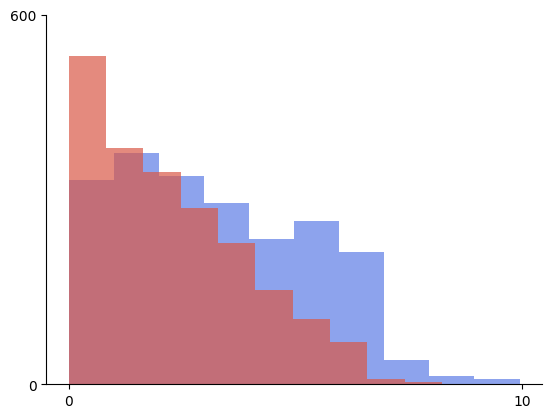

In [ ]:
import matplotlib.pyplot as plt

ax = plt.subplot()


cmap = plt.cm.get_cmap('coolwarm')

rgba = cmap(-10)

plt.hist(abs(IT_sel2), alpha=0.7, color=sns.color_palette("coolwarm_r", n_colors=8)[-1])
plt.hist(abs(IT_sel1), alpha=0.7, color=sns.color_palette("coolwarm_r", n_colors=8)[0])

plt.xticks([0, 10])
plt.yticks([0, 600])


ax.spines[['right', 'top']].set_visible(False)
plt.savefig("histogram.pdf", format="pdf")

In [ ]:
from scipy import stats

# Defining data groups
data_group1 = abs(IT_sel1)
data_group2 = abs(IT_sel2)


# Conduct the Kruskal-Wallis Test
result = stats.kruskal(data_group1, data_group2)

# Print the result
print(result)

KruskalResult(statistic=248.1832175576492, pvalue=6.464282160641052e-56)


# Human

In [ ]:
import scipy.io
import numpy as np
rh_fsaverage_x = scipy.io.loadmat(f'rh_x.mat')[f'x_rh']
rh_fsaverage_y = scipy.io.loadmat(f'rh_y.mat')[f'y_rh']
rh_fsaverage_ind = scipy.io.loadmat(f'rh_ind.mat')[f'ind_rh']
fsaverage_roi_patch1 = np.load(f'rh.all-vertices_fsaverage_space.npy')

In [ ]:
fmri = np.load('rh_training_fmri.npy')

In [ ]:
temp_rh = np.zeros((len(fsaverage_roi_patch1),1))
temp_rh[rh_fsaverage_ind] = 1
temp_rh = temp_rh.reshape(len(temp_rh),)

X_val = np.full((len(fsaverage_roi_patch1),), np.nan)
Y_val = np.full((len(fsaverage_roi_patch1),), np.nan)

X_val[temp_rh == 1,] = rh_fsaverage_x.reshape(np.size(rh_fsaverage_x,axis=1),)
Y_val[temp_rh == 1,] = rh_fsaverage_y.reshape(np.size(rh_fsaverage_y,axis=1),)

rh_patch1_data_with_xy = np.full((len(fsaverage_roi_patch1),2), np.nan)# 0: data; 1: x value; 2: y_value
rh_patch1_data_with_xy[:,0] = X_val
rh_patch1_data_with_xy[:,1] = Y_val

In [ ]:
valid_indices = np.where(fsaverage_roi_patch1 == 1)[0]

pos = rh_patch1_data_with_xy[valid_indices]
pos.shape

In [ ]:
def sem(x, axis=None):

    num_elements = x.shape[axis] if axis else len(x)
    return np.nanstd(x, axis=axis) / np.sqrt(num_elements)


def agg_by_distance(
    distances: np.ndarray,
    values: np.ndarray,
    bin_edges = None,
    num_bins: int = 10,
    agg_fn = np.nanmean,
    spread_fn = sem
):

    # sort distances and values in order of increasing distance
    dist_sort_ind = np.argsort(distances)
    sorted_distances = distances[dist_sort_ind]
    sorted_values = values[dist_sort_ind]

    # compute evenly-spaced bins for distances
    if bin_edges is None:
        bin_edges = np.histogram_bin_edges(sorted_distances, bins=num_bins)
    else:
        num_bins = len(bin_edges) - 1

    # iterate over bins, computing "means" (can be any aggregated value too) and spreads
    means = np.zeros((num_bins,))
    spreads = np.zeros((num_bins,))

    for i in range(1, num_bins + 1):
        bin_start = bin_edges[i - 1]
        bin_end = bin_edges[i]
        valid_values = sorted_values[
            (sorted_distances >= bin_start) & (sorted_distances < bin_end)
        ]
        if valid_values.shape[0] == 0:
            means[i - 1] = np.nan
            spreads[i - 1] = np.nan
        else:
            means[i - 1] = agg_fn(valid_values)
            spreads[i - 1] = spread_fn(valid_values)

    # return values for each bin along with the computed bin_edges
    return means, spreads, bin_edges

In [ ]:
from scipy.spatial.distance import pdist, squareform
from numpy import diff
import matplotlib.pyplot as plt


def lower_tri(x, keep_diagonal: bool = False):
    """return lower triangle of x, excluding diagonal"""
    assert len(x.shape) == 2
    return x[np.tril_indices_from(x, k=-1 if not keep_diagonal else 0)]

def midpoints_from_bin_edges(be):
    """Given `be`, a set of histogram bin edges, return the array of midpoints between
    those edges.
    """
    arr = np.array(be)
    width = arr[1] - arr[0]
    return arr[1:] - width / 2


def plot_correlation_between_pairwise_distances(num=100):


    fig, ax = plt.subplots(figsize=(2.5, 1.5), gridspec_kw={"wspace": 0.6},)

    activation = fmri.T#t.responses._data.T

    correlation = lower_tri(np.corrcoef(activation[:num, :]))
    dists = lower_tri(squareform(pdist(pos[:num, :]))) #t.positions


    nan_mask = np.isnan(correlation)
    correlation = correlation[~nan_mask]
    dists = dists[~nan_mask]

    means, spreads, bin_edges = agg_by_distance(
                    dists,
                    correlation,
                    num_bins=10,
                    bin_edges = np.linspace(0, 20, 14)
                )

    midpoints = midpoints_from_bin_edges(bin_edges)/20 * 100


    y_dataset = correlation
    delta = diff(y_dataset)
    std = np.std(delta)

    line_handle = ax.plot(
            midpoints, means,
            color = 'k',
            mec = 'k',
            mfc = "#ccc",

            markevery=2,
            markersize = 4,
            mew=0.5,
            lw=1.2,
            )


    ax.fill_between(
            midpoints,
            means - spreads,
            means + spreads,
            alpha=0.3,
            facecolor=line_handle[0].get_color(),
            )



    ax.legend().remove()
    ax.set_yticks([0,  1])


    ax.set_ylabel("Pairwise Correlation", labelpad=-1)
    ax.set_xlabel("Pairwise Distance(%)")



    plt.savefig("pairwise_activation_correlation_plot.png", bbox_inches='tight')
    plt.savefig("pairwise_activation_correlation_plot.pdf", format='pdf', bbox_inches='tight')


corr [ 0.07667449 -0.01302185 -0.04470988 ...  0.45370737  0.72320806
  0.89697216]
3.887340685722336e-09


0.08624098711309425
[0.74789677 0.56396752 0.47262323 0.41350903 0.36716758 0.32903225
 0.29781558 0.27224153 0.25060903 0.23230285 0.21593298 0.20084272
 0.18660126]
[0.00047937 0.00029979 0.00023529 0.00020262 0.00018172 0.00016631
 0.00015327 0.00014238 0.00013263 0.00012413 0.00011667 0.00011002
 0.00010469]


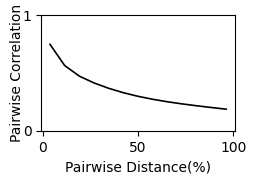

In [ ]:
plot_correlation_between_pairwise_distances(num=30000)